In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import concurrent.futures
from numba import jit

In [2]:
tidal_shear13 = np.load('/vol/calvin/data/adave/Internship/tidal_shear13.npy')

In [3]:
tidal_shear13.shape

(512, 512, 512, 3, 3)

In [4]:
# # Reshape tidal_shear to make it a 2D array with shape (512*512*512, 3, 3)
# tidal_shear_2d = tidal_shear.reshape(-1, 3, 3)

# # Initialize arrays to store eigenvalues and eigenvectors
# eigenvalues = np.zeros((512*512*512, 3))
# eigenvectors = np.zeros((512*512*512, 3, 3))

# # Calculate eigenvalues and eigenvectors using vectorized operations
# for idx in tqdm(range(512*512*512)):
#     eigenvalues[idx], eigenvectors[idx] = np.linalg.eig(tidal_shear_2d[idx])

# # Reshape eigenvalues and eigenvectors back to the original shape
# eigenvalues = eigenvalues.reshape(512, 512, 512, 3)
# eigenvectors = eigenvectors.reshape(512, 512, 512, 3, 3)


In [5]:
# Define the JIT-compiled function
@jit(nopython=True)
def calculate_eigenvalues_and_vectors(tidal_shear13):
    eigenvalues = np.zeros((512, 512, 512, 3))
    eigenvectors = np.zeros((512, 512, 512, 3, 3))

    for i in range(512):
        for j in range(512):
            for k in range(512):
                eigenvalues[i, j, k], eigenvectors[i, j, k] = np.linalg.eig(tidal_shear13[i, j, k])

    return eigenvalues, eigenvectors

import time
s1 = time.perf_counter()
# Call the JIT-compiled function
eigenvalues, eigenvectors = calculate_eigenvalues_and_vectors(tidal_shear13)

s2 = time.perf_counter()
print(s2-s1)

692.397859858349


In [6]:
eigenvalues.shape

(512, 512, 512, 3)

In [7]:
eigenvectors.shape

(512, 512, 512, 3, 3)

In [8]:
np.save("/vol/calvin/data/adave/Internship/eignvals_tidalshear13.npy", eigenvalues)

In [9]:
np.save("/vol/calvin/data/adave/Internship/eignvects_tidalshear13.npy", eigenvectors)

In [10]:
def classify_structure(eigenvalues):
    num_positive = np.sum(eigenvalues > 0)
    num_negative = np.sum(eigenvalues < 0)

    if num_positive == 0:
        return 0 # "Void"
    elif num_positive == 1 and num_negative == 2:
        return 1 # "Sheet"
    elif num_positive == 2 and num_negative == 1:
        return 2 # "Filament"
    elif num_positive == 3:
        return 3 # "Cluster"

In [11]:
classification_matrix = np.zeros((512, 512, 512))

for i in tqdm(range(512)):
    for j in range(512):
        for k in range(512):
            classification_matrix[i, j, k] = classify_structure(eigenvalues[i, j, k])

100%|██████████| 512/512 [37:53<00:00,  4.44s/it]


In [12]:
np.save("/vol/calvin/data/adave/Internship/Classification_matrix13.npy", classification_matrix)

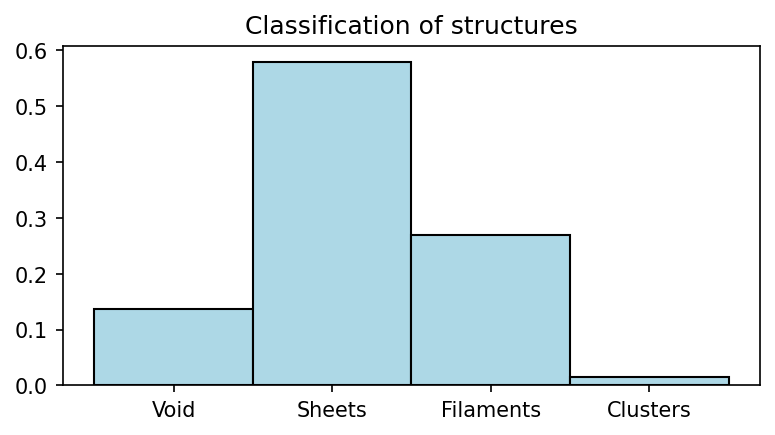

In [13]:
labels = ['Void', 'Sheets', 'Filaments', 'Clusters']

plt.figure(figsize=(6,3), dpi=150)
plt.title('Classification of structures', fontsize = 12)
plt.hist(classification_matrix.flatten(), bins=[-0.5, 0.5, 1.5, 2.5, 3.5], density = True, edgecolor='black', align='mid', color='lightblue')
plt.xticks(range(4), labels)
plt.show()

In [17]:
# Volume fraction of Sheets at small scales
np.sum(classification_matrix == 1) / 512**3

0.5792209729552269

In [18]:
# Volume fraction of Filaments at small scales
np.sum(classification_matrix == 2) / np.prod(classification_matrix.shape)

0.26991845667362213

In [5]:
c = np.load("/vol/calvin/data/adave/Internship/Classification_matrix13.npy")
val = np.load("/vol/calvin/data/adave/Internship/eignvals_tidalshear13.npy")
vecs = np.load("/vol/calvin/data/adave/Internship/eignvects_tidalshear13.npy")

In [6]:
cx = c.reshape(512**3)
vlx = val.reshape(512**3, 3)
vcx = vecs.reshape(512**3, 3, 3)

In [15]:
vlx[34505]

array([ 0.8593695 , -0.32600393, -1.09772064])

In [14]:
cx[34505]

1.0